In [1]:
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import datetime
import matplotlib.pyplot as plt
import numpy as np

#%load_ext tensorboard


In [ ]:
def create_train_validate_gen(model_type, rescaling_factor, image_path, image_size, batch_size, preprocess_input):
    # Create train and validate generators for bacteria data from ImageDataGenerator 

        
      # Train and validate generators    
    train_datagen = ImageDataGenerator(rescale = rescaling_factor,
                    horizontal_flip = True,
                    vertical_flip = True,                   
                    validation_split = 0.25,
                    preprocessing_function = preprocess_input)  
                
  
    train_generator = train_datagen.flow_from_directory(
                  image_path,
                  target_size = image_size,
                  batch_size = batch_size,
                  class_mode = 'categorical',
                  subset = 'training')
    
    validation_generator = train_datagen.flow_from_directory(
                       image_path, 
                       target_size = image_size,
                       batch_size = batch_size,
                       class_mode ='categorical',
                       subset ='validation')    # set as validation data)
    
    
    return train_datagen, train_generator, validation_generator
    

In [46]:
def create_model_head(model_type, baseModel, dense, dropout, num_classes):
    # Create model head to put atop pre-trained networks
    
    headModel = baseModel.output
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(dense, activation="relu")(headModel)
    headModel = Dropout(dropout)(headModel)
    #headModel = Dense(dense, activation="relu")(headModel)
    #headModel = Dropout(0.5)(headModel)
    headModel = Dense(num_classes, activation="softmax")(headModel)
    
    return headModel

def train_head_model(init_lr, batch_size, num_epochs, train_generator, validation_generator, callbacks):
    # Compile and train the head model component
    
    print("[INFO] compiling model...")
    opt = Adam(lr = init_lr, decay = init_lr / num_epochs)
    model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])
    

    print("[INFO] training head...")
    history = model.fit(train_generator,
              steps_per_epoch = train_generator.samples // batch_size,
              validation_data = validation_generator, 
              validation_steps = validation_generator.samples // batch_size,
              epochs = num_epochs,
              callbacks=[tensorboard_callback])
    
    return history

def plot_acc_loss(model_history):
    # Plot training/validation accuracy and loss
    
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, num_epochs), model_history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, num_epochs), model_history.history["val_loss"], label="val_loss")

    plt.title("Training Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc = "upper right")

    plt.figure()
    plt.plot(np.arange(0, num_epochs), model_history.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, num_epochs), model_history.history["val_accuracy"], label="val_acc")
    plt.title("Training Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend(loc = "lower left")

### Callbacks 

In [ ]:
# Early Stopping on validation loss
early_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',min_delta = 1e-3, patience = 5, mode = 'auto',verbose = 1)

 # VGG16 Model:

In [5]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input    

# VGG16 Model Parameters 
model_type = 'vgg16'
num_epochs = 35 
batch_size = 32
init_lr = 1e-3
rescaling_factor = None
image_path = './Bacteria/Train'
image_size = (224,224)

# Data generators
train_datagen, train_generator, validation_generator = create_train_validate_gen(model_type, rescaling_factor, image_path, image_size, batch_size, preprocess_input) 

# Create base model
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)), pooling = 'avg')

# Freeze kayers of base model
for layer in baseModel.layers:
    layer.trainable = False

# Create head model
headModel = create_model_head(model_type, baseModel, dense = 512, dropout = 0.2, num_classes = 33)

# Place the head FC model on top of the base model 
model = Model(inputs = baseModel.input, outputs = headModel)
   
# Create log directory for train and validate and callback
log_dir = "logs/VGG16/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1)

# Train model head
vgg16_history = train_head_model(init_lr, batch_size, num_epochs, train_generator, validation_generator, tensorboard_callback)    
   

# Save model    
model.save('./models/Vgg16_model') 

Found 557 images belonging to 33 classes.
Found 132 images belonging to 33 classes.
[INFO] compiling model...
[INFO] training head...
Epoch 1/50
 1/17 [>.............................] - ETA: 0s - loss: 3.8575 - accuracy: 0.0000e+00WARNING:tensorflow:From C:\Users\Ed\.conda\envs\tf\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
17/17 [==============================] - 177s 10s/step - loss: 3.5086 - accuracy: 0.0809 - val_loss: 2.5560 - val_accuracy: 0.2891
Epoch 2/50
17/17 [==============================] - 176s 10s/step - loss: 2.4857 - accuracy: 0.2514 - val_loss: 1.9411 - val_accuracy: 0.3750
Epoch 3/50
17/17 [==============================] - 172s 10s/step - loss: 1.9460 - accuracy: 0.3810 - val_loss: 1.4723 - val_accuracy: 0.5703
Epoch 4/50
17/17 [==============================] - 172s 10s/step - lo

INFO:tensorflow:Assets written to: ./models/Vgg16_model\assets


# VGG19 Model:

In [9]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input 

# VGG16 Model Parameters 
model_type = 'vgg19'
num_epochs = 35 
batch_size = 32
init_lr = 1e-3
rescaling_factor = None
image_path = './Bacteria/Train'
image_size = (224,224)

# Data generators
train_datagen, train_generator, validation_generator = create_train_validate_gen(model_type, rescaling_factor, image_path, image_size, batch_size, preprocess_input) 

# Create base model
baseModel = VGG19(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)), pooling = 'avg')

# Freeze kayers of base model
for layer in baseModel.layers:
    layer.trainable = False

# Create head model
headModel = create_model_head(model_type, baseModel, dense =  512, dropout = 0.2, num_classes = 33)

# Place the head FC model on top of the base model 
model = Model(inputs = baseModel.input, outputs = headModel)
   
# Create log directory for train and validate and callback
log_dir = "logs/VGG19/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1)

# Train model head
vgg19_history = train_head_model(init_lr, batch_size, num_epochs, train_generator, validation_generator, callbacks = tensorboard_callback)    
   
# Save model    
model.save('./models/Vgg19_model') 

Found 557 images belonging to 33 classes.
Found 132 images belonging to 33 classes.
[INFO] compiling model...
[INFO] training head...
Epoch 1/50
17/17 [==============================] - 221s 13s/step - loss: 3.7227 - accuracy: 0.0662 - val_loss: 3.0392 - val_accuracy: 0.1016
Epoch 2/50
17/17 [==============================] - 224s 13s/step - loss: 2.9938 - accuracy: 0.1657 - val_loss: 2.5611 - val_accuracy: 0.2969
Epoch 3/50
17/17 [==============================] - 221s 13s/step - loss: 2.6152 - accuracy: 0.2000 - val_loss: 2.1720 - val_accuracy: 0.3125
Epoch 4/50
17/17 [==============================] - 215s 13s/step - loss: 2.2953 - accuracy: 0.2971 - val_loss: 1.8834 - val_accuracy: 0.4688
Epoch 5/50
17/17 [==============================] - 215s 13s/step - loss: 2.1038 - accuracy: 0.3352 - val_loss: 1.6791 - val_accuracy: 0.5156
Epoch 6/50
17/17 [==============================] - 218s 13s/step - loss: 1.9088 - accuracy: 0.3543 - val_loss: 1.6295 - val_accuracy: 0.5234
Epoch 7/50
17/

# ResNet50 Model:

In [56]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

# ResNet50 Model Parameters 
model_type = 'resnet50'
num_epochs = 50 
batch_size = 32
init_lr = 1e-3
rescaling_factor = None
image_path = './Bacteria/Train'
image_size = (224,224)

# Data generators
train_datagen, train_generator, validation_generator = create_train_validate_gen(model_type, rescaling_factor, image_path, image_size, batch_size, preprocess_input) 

# Create base model
baseModel = ResNet50(include_top=False, weights = 'imagenet', input_tensor=Input(shape=(224, 224, 3)), pooling = 'avg')

# Freeze kayers of base model
for layer in baseModel.layers:
    layer.trainable = False

# Create head model
headModel = create_model_head(model_type, baseModel, dense = 512, dropout = 0.2, num_classes = 33)

# Place the head FC model on top of the base model 
model = Model(inputs = baseModel.input, outputs = headModel)
   
# Create log directory for train and validate and callback
res_log_dir = "logs/ResNet50/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = res_log_dir, histogram_freq = 1)

# Train model head
res50_history = train_head_model(init_lr, batch_size, num_epochs, train_generator, validation_generator, callbacks = [tensorboard_callback])    
   
# Save model    
model.save('./models/ResNet50_model') 


Found 557 images belonging to 33 classes.
Found 132 images belonging to 33 classes.
[INFO] compiling model...
[INFO] training head...
Epoch 1/50
17/17 [==============================] - 74s 4s/step - loss: 3.1002 - accuracy: 0.1893 - val_loss: 1.8776 - val_accuracy: 0.5000
Epoch 2/50
17/17 [==============================] - 69s 4s/step - loss: 1.7998 - accuracy: 0.4533 - val_loss: 0.9234 - val_accuracy: 0.7891
Epoch 3/50
17/17 [==============================] - 67s 4s/step - loss: 1.2560 - accuracy: 0.5924 - val_loss: 0.6429 - val_accuracy: 0.8359
Epoch 4/50
17/17 [==============================] - 67s 4s/step - loss: 0.9809 - accuracy: 0.6724 - val_loss: 0.5241 - val_accuracy: 0.8828
Epoch 5/50
17/17 [==============================] - 67s 4s/step - loss: 0.7430 - accuracy: 0.7543 - val_loss: 0.4515 - val_accuracy: 0.8438
Epoch 6/50
17/17 [==============================] - 67s 4s/step - loss: 0.6481 - accuracy: 0.7867 - val_loss: 0.3370 - val_accuracy: 0.8984
Epoch 7/50
17/17 [========

# Inception V3 Model:

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
# Inception V3 Model Parameters 
model_type = 'inceptionv3'
num_epochs = 30 
batch_size = 32
init_lr = 1e-3
rescaling_factor = None
image_path = './Bacteria/Train'
image_size = (299,299)

# Data generators
train_datagen, train_generator, validation_generator = create_train_validate_gen(model_type, rescaling_factor, image_path,image_size, batch_size, preprocess_input) 

# Create base model
baseModel = InceptionV3(include_top=False, weights = 'imagenet', input_tensor=Input(shape=(299, 299, 3)), pooling = 'avg')

# Freeze kayers of base model
for layer in baseModel.layers:
    layer.trainable = False

# Create head model
headModel = create_model_head(model_type, baseModel, dense = 256, dropout = 0.2, num_classes = 33)

# Place the head FC model on top of the base model 
model = Model(inputs = baseModel.input, outputs = headModel)
   
# Create log directory for train and validate and callback
inc_log_dir = "logs/InceptionV3/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = inc_log_dir, histogram_freq = 1)

# Train model head
incV3_history = train_head_model(init_lr, batch_size, num_epochs, train_generator, validation_generator, tensorboard_callback)    
   
# Save model    
model.save('./models/InceptionV3_model') 

Found 557 images belonging to 33 classes.
Found 132 images belonging to 33 classes.
[INFO] compiling model...
[INFO] training head...
Epoch 1/30
17/17 [==============================] - 107s 6s/step - loss: 2.6945 - accuracy: 0.2812 - val_loss: 1.5387 - val_accuracy: 0.6719
Epoch 2/30
17/17 [==============================] - 101s 6s/step - loss: 1.2040 - accuracy: 0.6971 - val_loss: 0.7997 - val_accuracy: 0.7969
Epoch 3/30
17/17 [==============================] - 98s 6s/step - loss: 0.7925 - accuracy: 0.7638 - val_loss: 0.5965 - val_accuracy: 0.8203
Epoch 4/30
17/17 [==============================] - 98s 6s/step - loss: 0.5634 - accuracy: 0.8305 - val_loss: 0.5251 - val_accuracy: 0.8672
Epoch 5/30
17/17 [==============================] - 99s 6s/step - loss: 0.4384 - accuracy: 0.8686 - val_loss: 0.5295 - val_accuracy: 0.8516
Epoch 6/30
17/17 [==============================] - 98s 6s/step - loss: 0.3771 - accuracy: 0.8800 - val_loss: 0.3450 - val_accuracy: 0.9141
Epoch 7/30
17/17 [======

In [51]:
#model.save('./models/InceptionV3_model') 
# Tensor board



In [ ]:
model = tensorflow.keras.models.load_model('./models/InceptionV3_model')

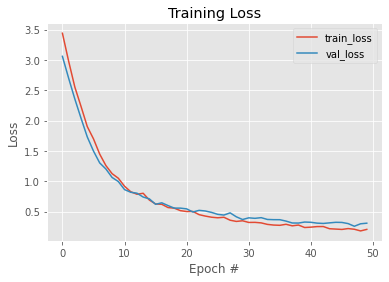

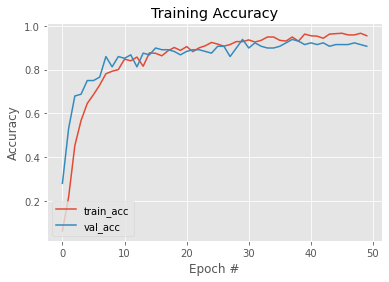

In [56]:
plot_acc_loss(incV3_history)